## EENG 439: Neural Networks and Learning Systems Final Project

### Corn Future Predictions using Convolutional Neural Networks

In [171]:
# Install Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta
import pickle
from functools import reduce

In [172]:
## Load in the data
corn_files = ['USDAProj_Corn_2017to2018.csv',
'USDAProj_Corn_2016to2017.csv',
'USDAProj_Corn_2015to2016.csv',
'USDAProj_Corn_2009to2010.csv',
'USDAProj_Corn_2014to2015.csv',
'USDAProj_Corn_2013to2014.csv',
'USDAProj_Corn_2012to2013.csv',
'USDAProj_Corn_2011to2012.csv',
'USDAProj_Corn_2010to2011.csv',
'USDAProj_Corn_2008to2009.csv',
'USDAProj_Corn_2007to2008.csv']

soybeans_files = ['USDAProj_Soybean_2017to2018.csv',
'USDAProj_Soybean_2016to2017.csv',
'USDAProj_Soybean_2015to2016.csv',
'USDAProj_Soybean_2009to2010.csv',
'USDAProj_Soybean_2014to2015.csv',
'USDAProj_Soybean_2013to2014.csv',
'USDAProj_Soybean_2012to2013.csv',
'USDAProj_Soybean_2011to2012.csv',
'USDAProj_Soybean_2010to2011.csv',
'USDAProj_Soybean_2008to2009.csv',
'USDAProj_Soybean_2007to2008.csv']

corn_files.sort()
soybeans_files.sort()

monthly_corn_data = pd.read_csv('Data/USDAProj_Corn_2007to2008.csv')
for file in corn_files[1:]:
    file_path = str('Data/' + file)
    monthly_corn_data = monthly_corn_data.append(pd.read_csv(file_path))
monthly_corn_data.sort_values(by="Date")
    
corn_prices = pd.read_csv('Data/Corn_prices.csv')
corn_prices_new = pd.read_csv('Data/corn_prices_edited.csv')

monthly_soybean_data = pd.read_csv('Data/USDAProj_Soybean_2007to2008.csv')
for file in soybeans_files[1:]:
    file_path = str('Data/' + file)
    monthly_soybean_data = monthly_soybean_data.append(pd.read_csv(file_path))
    
monthly_soybean_data.sort_values(by="Date")
    
soybean_prices = pd.read_csv('Data/Soybean_prices.csv')

weather = pd.read_csv('Data/weather_data_iowa.csv')

In [173]:
weather

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TMAX,TMIN,WDMV,WSF2,WSF5
0,USW00014933,41.53380,-93.65300,291.7,2004-01-01,0.00,52.0,27.0,NaN,21.0,23.0
1,USW00014933,41.53380,-93.65300,291.7,2004-01-02,0.00,60.0,31.0,NaN,21.0,25.9
2,USW00014933,41.53380,-93.65300,291.7,2004-01-03,0.00,34.0,20.0,NaN,19.9,21.9
3,USW00014933,41.53380,-93.65300,291.7,2004-01-04,0.30,21.0,11.0,NaN,21.9,29.1
4,USW00014933,41.53380,-93.65300,291.7,2004-01-05,0.00,11.0,-5.0,NaN,23.9,29.1
...,...,...,...,...,...,...,...,...,...,...,...
23353,USW00094988,42.11056,-92.91611,296.9,2019-12-27,0.00,40.0,21.0,NaN,18.1,23.0
23354,USW00094988,42.11056,-92.91611,296.9,2019-12-28,0.84,49.0,31.0,NaN,21.9,27.1
23355,USW00094988,42.11056,-92.91611,296.9,2019-12-29,0.01,52.0,30.0,NaN,23.9,35.1
23356,USW00094988,42.11056,-92.91611,296.9,2019-12-30,0.00,30.0,22.0,NaN,28.0,40.0


In [174]:
#check shapes
print(monthly_corn_data.shape)
print(monthly_soybean_data.shape)

print(corn_prices.shape)
print(soybean_prices.shape)

(248, 113)
(248, 70)
(1035, 8)
(942, 8)


In [175]:
monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007/05/11,90.5,82.9,150.3,937.0,12460.0,15.0,13412.0,5700.0,4790.0,...,21.35,0.24,1.95,10.42,55.37,3.5,45.3,60.3,0.3,8.69
1,2007/06/11,90.5,82.9,150.3,987.0,12460.0,15.0,13462.0,5700.0,4790.0,...,21.35,0.24,1.95,10.72,55.72,3.5,45.8,60.8,0.3,8.84
2,2007/07/12,92.9,85.4,150.3,1137.0,12840.0,15.0,13992.0,5700.0,4790.0,...,21.35,0.24,1.97,10.72,55.23,3.5,45.8,60.8,0.3,8.35
3,2007/08/10,92.9,85.4,152.8,1137.0,13054.0,15.0,14206.0,5750.0,4790.0,...,21.35,0.24,1.92,10.72,48.43,6.0,45.8,60.8,0.3,4.05
4,2007/09/12,92.9,85.4,155.8,1142.0,13308.0,15.0,14465.0,5850.0,4690.0,...,21.35,0.24,1.77,10.62,46.94,8.0,46.5,61.5,0.3,3.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2017/11/09,90.4,83.1,175.4,2295.0,14578.0,50.0,16922.0,5575.0,6935.0,...,43.70,0.72,2.67,7.09,59.59,16.0,56.0,74.7,1.5,6.47
7,2017/12/12,90.4,83.1,175.4,2295.0,14578.0,50.0,16922.0,5575.0,6985.0,...,43.70,0.72,2.77,7.55,60.09,16.0,56.0,74.8,2.0,6.84
8,2018/01/12,90.2,82.7,176.6,2293.0,14604.0,50.0,16947.0,5550.0,6995.0,...,43.70,0.82,2.75,7.54,60.09,16.0,56.0,74.8,2.0,6.83
9,2018/02/08,90.2,82.7,176.6,2293.0,14604.0,50.0,16947.0,5550.0,6995.0,...,43.80,0.82,2.73,7.54,60.09,16.2,56.2,75.0,2.0,6.83


In [176]:
#no NA rows
len(monthly_corn_data[monthly_corn_data.isna().any(axis=1)]) == 0
len(monthly_soybean_data[monthly_soybean_data.isna().any(axis=1)]) == 0
len(corn_prices[corn_prices.isna().any(axis=1)]) == 0
len(soybean_prices[soybean_prices.isna().any(axis=1)]) == 0

True

In [177]:
#normalize the prices data
normalized_monthly_corn_data=(monthly_corn_data.iloc[:,1:]-monthly_corn_data.iloc[:,1:].min())
normalized_monthly_corn_data = normalized_monthly_corn_data/normalized_monthly_corn_data.max()
#normalized_monthly_corn_data.drop_duplicates().reset_index(drop=True)
#insert the data back in
normalized_monthly_corn_data.insert(0, 'Date', monthly_corn_data['Date'])#.drop_duplicates().reset_index(drop=True))
#sort values
normalized_monthly_corn_data = normalized_monthly_corn_data.sort_values(by='Date').reset_index(drop=True)

In [178]:
normalized_monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007/05/11,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.000000,0.824859
1,2007/06/11,0.443548,0.435897,0.518315,0.190755,0.388053,0.044586,0.322845,0.783133,0.180000,...,0.016529,0.104167,0.180791,1.000000,0.317347,0.105634,0.155556,0.127273,0.000000,0.846045
2,2007/07/12,0.637097,0.649573,0.518315,0.278525,0.472124,0.044586,0.423913,0.783133,0.180000,...,0.016529,0.104167,0.186441,1.000000,0.300680,0.105634,0.155556,0.127273,0.000000,0.776836
3,2007/08/10,0.637097,0.649573,0.564103,0.278525,0.519469,0.044586,0.464722,0.807229,0.180000,...,0.016529,0.104167,0.172316,1.000000,0.069388,0.281690,0.155556,0.127273,0.000000,0.169492
4,2007/09/12,0.637097,0.649573,0.619048,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,...,0.016529,0.104167,0.129944,0.986468,0.018707,0.422535,0.194444,0.159091,0.000000,0.128531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2018/01/12,0.419355,0.418803,1.000000,0.954944,0.862389,0.267516,0.987414,0.710843,0.981818,...,0.940083,0.506944,0.406780,0.569689,0.465986,0.985915,0.722222,0.763636,0.455764,0.562147
244,2018/02/08,0.419355,0.418803,1.000000,0.954944,0.862389,0.267516,0.987414,0.710843,0.981818,...,0.944215,0.506944,0.401130,0.569689,0.465986,1.000000,0.733333,0.772727,0.455764,0.562147
245,2018/02/08,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.670843,0.943273,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.501340,0.662429
246,2018/03/08,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.501340,0.662429


In [179]:
to_delete = []
#get rid of the duplicate reports because there are two of each from overlapping years
for i in range(1,len(normalized_monthly_corn_data)):
    if normalized_monthly_corn_data['Date'][i] == normalized_monthly_corn_data['Date'][i-1]:
        to_delete.append(i)

In [180]:
#drops the rows to delete and resets index
normalized_monthly_corn_data = normalized_monthly_corn_data.drop(to_delete).reset_index(drop=True)

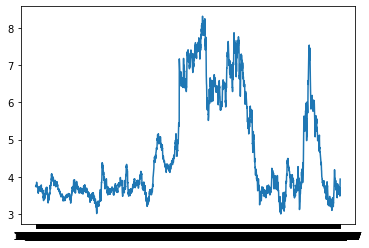

In [181]:
corn_prices_new = corn_prices_new[corn_prices_new['Close'] != 0]
plt.plot(corn_prices_new['Date'], corn_prices_new['Close'])

In [182]:
normalized_monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007/05/11,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.000000,0.824859
1,2007/06/11,0.443548,0.435897,0.518315,0.190755,0.388053,0.044586,0.322845,0.783133,0.180000,...,0.016529,0.104167,0.180791,1.000000,0.317347,0.105634,0.155556,0.127273,0.000000,0.846045
2,2007/07/12,0.637097,0.649573,0.518315,0.278525,0.472124,0.044586,0.423913,0.783133,0.180000,...,0.016529,0.104167,0.186441,1.000000,0.300680,0.105634,0.155556,0.127273,0.000000,0.776836
3,2007/08/10,0.637097,0.649573,0.564103,0.278525,0.519469,0.044586,0.464722,0.807229,0.180000,...,0.016529,0.104167,0.172316,1.000000,0.069388,0.281690,0.155556,0.127273,0.000000,0.169492
4,2007/09/12,0.637097,0.649573,0.619048,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,...,0.016529,0.104167,0.129944,0.986468,0.018707,0.422535,0.194444,0.159091,0.000000,0.128531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2017/11/09,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.668916,0.944000,...,0.898760,0.819444,0.488701,0.454668,0.500340,0.901408,0.661111,0.704545,0.455764,0.598870
126,2017/12/12,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.668916,0.944000,...,0.898760,0.819444,0.516949,0.458728,0.512245,0.933099,0.666667,0.713636,0.501340,0.663842
127,2018/01/12,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.670843,0.943273,...,0.898760,0.819444,0.528249,0.458728,0.512245,0.932394,0.666667,0.713636,0.501340,0.662429
128,2018/02/08,0.419355,0.418803,1.000000,0.954944,0.862389,0.267516,0.987414,0.710843,0.981818,...,0.944215,0.506944,0.401130,0.569689,0.465986,1.000000,0.733333,0.772727,0.455764,0.562147


In [183]:
#convert the dates to datetime
corn_prices['dates'] = pd.to_datetime(corn_prices['dates'])
normalized_monthly_corn_data['Date'] = pd.to_datetime(normalized_monthly_corn_data['Date'])

In [184]:
normalized_monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007-05-11,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.000000,0.824859
1,2007-06-11,0.443548,0.435897,0.518315,0.190755,0.388053,0.044586,0.322845,0.783133,0.180000,...,0.016529,0.104167,0.180791,1.000000,0.317347,0.105634,0.155556,0.127273,0.000000,0.846045
2,2007-07-12,0.637097,0.649573,0.518315,0.278525,0.472124,0.044586,0.423913,0.783133,0.180000,...,0.016529,0.104167,0.186441,1.000000,0.300680,0.105634,0.155556,0.127273,0.000000,0.776836
3,2007-08-10,0.637097,0.649573,0.564103,0.278525,0.519469,0.044586,0.464722,0.807229,0.180000,...,0.016529,0.104167,0.172316,1.000000,0.069388,0.281690,0.155556,0.127273,0.000000,0.169492
4,2007-09-12,0.637097,0.649573,0.619048,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,...,0.016529,0.104167,0.129944,0.986468,0.018707,0.422535,0.194444,0.159091,0.000000,0.128531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2017-11-09,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.668916,0.944000,...,0.898760,0.819444,0.488701,0.454668,0.500340,0.901408,0.661111,0.704545,0.455764,0.598870
126,2017-12-12,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.668916,0.944000,...,0.898760,0.819444,0.516949,0.458728,0.512245,0.933099,0.666667,0.713636,0.501340,0.663842
127,2018-01-12,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.670843,0.943273,...,0.898760,0.819444,0.528249,0.458728,0.512245,0.932394,0.666667,0.713636,0.501340,0.662429
128,2018-02-08,0.419355,0.418803,1.000000,0.954944,0.862389,0.267516,0.987414,0.710843,0.981818,...,0.944215,0.506944,0.401130,0.569689,0.465986,1.000000,0.733333,0.772727,0.455764,0.562147


In [185]:
price_years = []
for i in range(len(corn_prices['dates'])):
    price_years.append(corn_prices['dates'][i].year)
    
price_years = np.unique(price_years)

In [186]:
data_years = []
for i in range(len(normalized_monthly_corn_data['Date'])):
    data_years.append(normalized_monthly_corn_data['Date'][i].year)
    
data_years = np.unique(data_years)

In [187]:
#years to get
data_years

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])

In [188]:
#finds how many days are missing between each report
to_add = []
for i in range(len(normalized_monthly_corn_data)-1):
    if (normalized_monthly_corn_data['Date'][i+1] - normalized_monthly_corn_data['Date'][i]).days > 0: 
        to_add.append((normalized_monthly_corn_data['Date'][i+1] - normalized_monthly_corn_data['Date'][i]).days)
    else:
        to_add.append(365 - (normalized_monthly_corn_data['Date'][i] - normalized_monthly_corn_data['Date'][i+1]).days)
to_add.append(30)

In [189]:
np.mean(to_add)

30.646153846153847

In [190]:
number = 0
for add in to_add:
    number += add
number

3984

In [191]:
#repeats the rows of data
normalized_monthly_corn_data = normalized_monthly_corn_data.loc[normalized_monthly_corn_data.index.repeat(to_add)].reset_index(drop=True)

In [192]:
#writes over for the correct dates
for i in range(1,len(normalized_monthly_corn_data)):
    normalized_monthly_corn_data['Date'][i] = normalized_monthly_corn_data['Date'][i-1]+timedelta(days=1)
normalized_monthly_corn_data

<ipython-input-192-7a1f060d88e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_monthly_corn_data['Date'][i] = normalized_monthly_corn_data['Date'][i-1]+timedelta(days=1)


,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007-05-11,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
1,2007-05-12,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
2,2007-05-13,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
3,2007-05-14,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
4,2007-05-15,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,2018-04-02,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.50134,0.662429
3980,2018-04-03,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.50134,0.662429
3981,2018-04-04,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.50134,0.662429
3982,2018-04-05,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.50134,0.662429


In [193]:
#corn_year_dict = {}

#for year in price_years:
#    corn_year_dict[year] = pd.DataFrame(columns = corn_prices.columns)
##    for i in range(len(corn_prices)):
 #       if corn_prices['dates'][i].year == year:
 #           corn_year_dict[year] = corn_year_dict[year].append(corn_prices.iloc[i,:])
 #           
 #   plt.plot(corn_year_dict[year]['dates'], corn_year_dict[year]['Close'])
 #   plt.show()

In [194]:
#corn_year_dict_new

In [195]:
#np.sort(corn_year_dict_new[key]['Close'])[-20]

In [196]:
#corn_year_dict_new[key]['Close']

In [197]:
corn_prices_new['Date'] = pd.to_datetime(corn_prices_new['Date'])

In [198]:
corn_prices_new

,Open,Close,High,Low,Volume,Date
0,3.7550,3.7500,3.7700,3.7275,NaN,2018-12-31
1,3.7450,3.7550,3.7750,3.7450,NaN,2018-12-28
2,3.7325,3.7450,3.7650,3.7325,NaN,2018-12-27
3,3.7825,3.7325,3.7925,3.7250,NaN,2018-12-26
4,3.7825,3.7775,3.7900,3.7525,NaN,2018-12-24
...,...,...,...,...,...,...
2952,3.5975,3.6025,3.6100,3.5875,NaN,2007-04-04
2953,3.4700,3.4850,3.5000,3.4700,NaN,2007-04-03
2954,3.5600,3.5700,3.5725,3.5500,NaN,2007-04-02
2955,0.0000,3.7450,3.9775,3.7400,NaN,2007-03-30


In [199]:
#normalize the prices
corn_prices_new1 = (corn_prices_new.iloc[:,:-1]-corn_prices_new.iloc[:,:-1].min())
corn_prices_new1 = corn_prices_new1/ corn_prices_new1.max()
corn_prices_new1['Date'] = corn_prices_new['Date']
corn_prices_new = corn_prices_new1


In [200]:
#normalize the weather
weather['Date'] = pd.to_datetime(weather['DATE'])
weather_subset = weather[weather['STATION'] == 'USW00014933']
weather_subset = weather_subset[list(weather_subset.columns[-7:])]

weather_subset1 = (weather_subset.iloc[:,:-1]-weather_subset.iloc[:,:-1].min())
weather_subset1 = weather_subset1 / weather_subset1.max()
weather_subset1['Date'] = weather_subset['Date']
weather_subset = weather_subset1
weather_subset['PRCP']

0       0.000000
1       0.000000
2       0.000000
3       0.066225
4       0.000000
          ...   
5839    0.000000
5840    0.185430
5841    0.000000
5842    0.000000
5843    0.000000
Name: PRCP, Length: 5844, dtype: float64

In [201]:
#merge the data
full_data = corn_prices_new.merge(weather_subset, how = 'left', on = 'Date' )
full_data = full_data.merge(normalized_monthly_corn_data, how = 'left', on = 'Date' )
full_data 

,Open,Close,High,Low,Volume,Date,PRCP,TMAX,TMIN,WDMV,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,0.452273,0.140367,0.446815,0.453054,NaN,2018-12-31,0.024283,0.371681,0.396040,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.451069,0.141309,0.447407,0.455181,NaN,2018-12-28,0.002208,0.309735,0.326733,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.449563,0.139425,0.446222,0.453662,NaN,2018-12-27,0.198675,0.539823,0.475248,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.455586,0.137070,0.449481,0.452750,NaN,2018-12-26,0.121413,0.424779,0.495050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.455586,0.145549,0.449185,0.456092,NaN,2018-12-24,0.000000,0.380531,0.386139,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,0.433303,0.112577,0.427852,0.436038,NaN,2007-04-04,0.000000,0.389381,0.396040,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2930,0.417946,0.090438,0.414815,0.421756,NaN,2007-04-03,0.070640,0.522124,0.445545,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2931,0.428787,0.106453,0.423407,0.431480,NaN,2007-04-02,0.000000,0.610619,0.594059,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,0.000000,0.139425,0.471407,0.454573,NaN,2007-03-30,0.048565,0.699115,0.742574,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
#take the subset of meaningful fields
subset = full_data[['Date', 'Close', 'High', 'Low','PRCP',
 'TMAX',
 'TMIN',
 'WSF2',
 'WSF5','Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use']]

#drop zeros
subset = subset[subset['Close']!= -3.204636436946188].sort_values(by='Date', ascending = True).reset_index(drop=True)

#generates the time lags
def generate_time_lags(df,col, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n, col}"] = df_n[col].shift(n)
    #df_n = df_n.iloc[n_lags:]
    
    
    return df_n


df_generated = subset

#calls the lag function on the subset
for column in list(df_generated.keys())[1:]:
    df_generated = generate_time_lags(df_generated, column, 20)
df_generated


,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,"lag(11, 'Total Use')","lag(12, 'Total Use')","lag(13, 'Total Use')","lag(14, 'Total Use')","lag(15, 'Total Use')","lag(16, 'Total Use')","lag(17, 'Total Use')","lag(18, 'Total Use')","lag(19, 'Total Use')","lag(20, 'Total Use')"
0,2007-03-29,0.176166,0.467259,0.477059,0.002208,0.575221,0.712871,0.100749,0.119390,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-03-30,0.139425,0.471407,0.454573,0.048565,0.699115,0.742574,0.084097,0.110076,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-04-02,0.106453,0.423407,0.431480,0.000000,0.610619,0.594059,0.108243,0.127011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-04-03,0.090438,0.414815,0.421756,0.070640,0.522124,0.445545,0.266445,0.314987,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-04-04,0.112577,0.427852,0.436038,0.000000,0.389381,0.396040,0.225645,0.280271,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,2018-12-24,0.145549,0.449185,0.456092,0.000000,0.380531,0.386139,0.067444,0.085521,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2930,2018-12-26,0.137070,0.449481,0.452750,0.121413,0.424779,0.495050,0.109908,0.195597,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2931,2018-12-27,0.139425,0.446222,0.453662,0.198675,0.539823,0.475248,0.218152,0.280271,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,2018-12-28,0.141309,0.447407,0.455181,0.002208,0.309735,0.326733,0.168193,0.238781,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
subset

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use
0,2007-03-29,0.176166,0.467259,0.477059,0.002208,0.575221,0.712871,0.100749,0.119390,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-03-30,0.139425,0.471407,0.454573,0.048565,0.699115,0.742574,0.084097,0.110076,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-04-02,0.106453,0.423407,0.431480,0.000000,0.610619,0.594059,0.108243,0.127011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-04-03,0.090438,0.414815,0.421756,0.070640,0.522124,0.445545,0.266445,0.314987,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-04-04,0.112577,0.427852,0.436038,0.000000,0.389381,0.396040,0.225645,0.280271,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,2018-12-24,0.145549,0.449185,0.456092,0.000000,0.380531,0.386139,0.067444,0.085521,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2930,2018-12-26,0.137070,0.449481,0.452750,0.121413,0.424779,0.495050,0.109908,0.195597,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2931,2018-12-27,0.139425,0.446222,0.453662,0.198675,0.539823,0.475248,0.218152,0.280271,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,2018-12-28,0.141309,0.447407,0.455181,0.002208,0.309735,0.326733,0.168193,0.238781,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
#create a list of matrices
subset_matrices = []
for i in range(len(subset)):
    subset_matrices.append(subset.iloc[i-22:i,0:23])


In [205]:
subset_matrices[22].isnull().values.any()

True

In [206]:
#create the dict of matrices
matrices_dict = {}
i = 0
for year in data_years:
    
    days_since_harvest = 0
    
    matrices_dict[year] = []
    
    while subset_matrices[i+22]['Date'][i].month != 10 or subset_matrices[i+22]['Date'][i].year != year:

    #for i in range(len(corn_prices_new)):
        #if corn_prices_new['Date'][i].year == year:
            #add the days since harvest
            subset_matrices[i+1]['Days Since Harvest'] = [x for x in range(days_since_harvest-21, days_since_harvest+1)]
            matrices_dict[year].append(subset_matrices[i+1])
            i = i + 1
            days_since_harvest = days_since_harvest +1

In [207]:
subset_matrices[1000]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest
978,2011-04-07,0.863872,0.916444,0.914919,0.269316,0.566372,0.643564,0.108243,0.127011,0.112903,...,0.527876,0.000000,0.573036,0.513253,0.597818,0.616381,0.432210,0.715000,0.527478,136
979,2011-04-08,0.880829,0.911704,0.913096,0.000000,0.548673,0.683168,0.084097,0.119390,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,137
980,2011-04-11,0.895902,0.928889,0.923731,0.000000,0.654867,0.633663,0.168193,0.204911,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,138
981,2011-04-12,0.851625,0.919111,0.907627,0.000000,0.681416,0.603960,0.059950,0.127011,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,139
982,2011-04-13,0.857277,0.910815,0.907323,0.000000,0.725664,0.702970,0.192340,0.221846,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,140
983,2011-04-14,0.854922,0.901037,0.900942,0.041943,0.619469,0.653465,0.201499,0.270957,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,141
984,2011-04-15,0.831842,0.898667,0.898815,0.203091,0.477876,0.594059,0.201499,0.270957,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,142
985,2011-04-18,0.850212,0.892741,0.891826,0.002208,0.469027,0.594059,0.124896,0.154107,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,143
986,2011-04-19,0.845031,0.897481,0.908538,0.198675,0.442478,0.544554,0.249792,0.304826,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,144
987,2011-04-20,0.814414,0.910222,0.885749,0.000000,0.522124,0.544554,0.124896,0.178662,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,145


In [208]:
#normalize the days since harvest
for key in matrices_dict.keys():
    length = [x for x in range(-21, len(matrices_dict[key]))]
    
    for i in range(len(matrices_dict[key])):
        matrices_dict[key][i]['Days Since Harvest'] = (matrices_dict[key][i]['Days Since Harvest'] - np.min(length))
        matrices_dict[key][i]['Days Since Harvest'] = (matrices_dict[key][i]['Days Since Harvest'] / (np.max(length)+21))

In [209]:
matrices_dict[2008][-1]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest
331,2008-08-25,0.527084,0.721481,0.703130,0.000000,0.752212,0.772277,0.076603,NaN,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.914286
332,2008-08-26,0.517664,0.691259,0.690672,0.000000,0.761062,0.772277,0.093256,0.110076,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.918367
333,2008-08-27,0.521903,0.693630,0.689456,0.037528,0.752212,0.801980,0.158201,0.187976,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.922449
334,2008-08-28,0.507772,0.685630,0.685202,0.000000,0.814159,0.841584,0.093256,0.143946,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.926531
335,2008-09-01,0.504475,0.673481,0.690672,0.000000,0.858407,0.851485,0.124896,0.160881,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.930612
336,2008-09-02,0.475742,0.664000,0.652081,0.002208,0.840708,0.821782,0.158201,0.178662,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.934694
337,2008-09-03,0.463495,0.662519,0.649043,0.000000,0.637168,0.742574,0.108243,0.143946,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.938776
338,2008-09-04,0.468676,0.659556,0.656335,0.116998,0.646018,0.722772,0.093256,0.119390,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.942857
339,2008-09-08,0.438059,0.642370,0.641750,0.083885,0.592920,0.663366,0.084097,0.110076,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.946939
340,2008-09-09,0.431465,0.632889,0.627165,0.000000,0.663717,0.633663,0.050791,NaN,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.951020


In [167]:
#make a dictionary 
def make_year_dict(corn_price):
    price_years_new = []
    for i in range(len(corn_price['Date'])):
        price_years_new.append(corn_price['Date'][i].year)

    price_years_new = np.unique(price_years_new)
    
    to_delete = []
    for i in tqdm(range(len(corn_price))):
        if corn_price['Close'][i] == -3.204636436946188:
            to_delete.append(i)
            
    corn_price = corn_price.drop(to_delete)
    corn_price = corn_price.reset_index(drop=True)
    
    corn_price = corn_price.sort_values(by = 'Date').reset_index(drop=True)
    
    corn_year_dict_new = {}

    i = 0
    for year in price_years_new:
        corn_year_dict_new[year] = pd.DataFrame(columns = corn_price.columns)

        while corn_price['Date'][i].month != 10 or corn_price['Date'][i].year != year:

        #for i in range(len(corn_prices_new)):
            #if corn_prices_new['Date'][i].year == year:
                corn_year_dict_new[year] = corn_year_dict_new[year].append(corn_price.iloc[i,:])
                i = i + 1

        corn_year_dict_new[year] = corn_year_dict_new[year].reset_index(drop=True)
        #plt.plot(corn_year_dict_new[year]['Date'], corn_year_dict_new[year]['Close'])
        #plt.show()
        
    return corn_year_dict_new

In [168]:
#regular data
regular_dict = make_year_dict(full_data)

100%|██████████| 2957/2957 [00:00<00:00, 82745.50it/s]


In [169]:
#lagged data
lagged_dict = make_year_dict(df_generated)

100%|██████████| 2934/2934 [00:00<00:00, 70791.37it/s]


In [170]:
subset_dict = make_year_dict(subset)

100%|██████████| 2934/2934 [00:00<00:00, 64947.32it/s]


In [171]:
subset_dict[2008]



,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use
0,2007-10-01,-0.626041,-0.556610,-0.554022,-0.334083,0.607506,0.747199,0.077627,0.416007,0.501137,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
1,2007-10-02,-0.765897,-0.608131,-0.685953,4.013997,0.517957,0.410835,1.812521,2.332146,0.501137,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
2,2007-10-03,-0.795616,-0.722806,-0.730501,-0.334083,0.562732,0.218627,-0.624933,-0.722406,0.501137,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
3,2007-10-04,-0.811350,-0.734440,-0.739068,-0.334083,0.920928,0.554991,-0.495891,-0.496977,0.501137,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
4,2007-10-05,-0.811350,-0.774327,-0.749349,-0.334083,1.055252,1.179668,0.780187,0.765420,0.501137,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2008-09-23,0.713081,0.674899,0.689900,-0.207132,0.920928,1.035512,0.077627,-0.046121,0.695806,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
221,2008-09-24,0.732311,0.756335,0.727594,0.078508,0.786605,0.891355,0.077627,-0.271549,0.695806,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
222,2008-09-25,0.699095,0.699829,0.727594,-0.334083,0.831379,0.699147,-0.782651,-1.049276,0.695806,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
223,2008-09-29,0.382671,0.545267,0.419184,1.760612,0.428408,0.458887,0.780187,0.641435,0.695806,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097


In [172]:
#old labeling
def label(corn_year_dict_new):
    for key in corn_year_dict_new.keys():
        labels = []
        sell_threshold = np.sort(corn_year_dict_new[key]['Close'])[-20]
        buy_threshold = np.sort(corn_year_dict_new[key]['Close'])[20]
        for i in range(len(corn_year_dict_new[key])):
            if corn_year_dict_new[key]['Close'][i] >= sell_threshold:
                labels.append(2)
            elif corn_year_dict_new[key]['Close'][i] <= buy_threshold:
                labels.append(0)
            else:
                labels.append(1)

        corn_year_dict_new[key]['Days Since Harvest'] = (np.array(corn_year_dict_new[key].index) - np.array(corn_year_dict_new[key].index).mean())/np.array(corn_year_dict_new[key].index).std()
        
        corn_year_dict_new[key]['Labels'] = labels

    return corn_year_dict_new

In [173]:
#new labeling
def label_updated(corn_year_dict_new,n):
    for key in corn_year_dict_new.keys():
        labels = []
        
        for i in range(len(corn_year_dict_new[key])):
            
            if i-n<0:
                window = corn_year_dict_new[key]['Close'][0:i+n]
            elif i+10>len(corn_year_dict_new[key]['Close']):
                window = corn_year_dict_new[key]['Close'][i-n:len(corn_year_dict_new[key]['Close'])]
            else:
                window = corn_year_dict_new[key]['Close'][i-n:i+n]
                
            if max(window) == corn_year_dict_new[key]['Close'][i]:
                labels.append(2)
            elif min(window) == corn_year_dict_new[key]['Close'][i]:
                labels.append(0)
            else:
                labels.append(1)

        corn_year_dict_new[key]['Days Since Harvest'] = (np.array(corn_year_dict_new[key].index) - np.array(corn_year_dict_new[key].index).mean())/np.array(corn_year_dict_new[key].index).std()
        
        corn_year_dict_new[key]['Labels'] = labels

    return corn_year_dict_new

In [174]:
labeled_dict = label(regular_dict)
min(labeled_dict[2008]['Labels'])

0

In [271]:
#create the two dictionaries for lagged data
labeled_dict_lagged = label_updated(lagged_dict, 5)

labeled_dict_lagged[2008]

data_lagged = {}
label_lagged = {}
for key in labeled_dict_lagged.keys():
    data_lagged[key] = labeled_dict_lagged[key].iloc[:,:-1]
    label_lagged[key] = labeled_dict_lagged[key].iloc[:,-1]

In [272]:
label_lagged[2008]

0      2
1      1
2      1
3      1
4      1
      ..
220    1
221    2
222    1
223    1
224    0
Name: Labels, Length: 225, dtype: int64

In [273]:
del data_lagged[2018]
del data_lagged[2007]
del label_lagged[2018]
del label_lagged[2007]

In [274]:
#check the labeling
sells = {}
buys = {}
for key in label_lagged.keys():
    sell = []
    buy = []
    for i in range(len(label_lagged[key])):
        if label_lagged[key][i] == 2:
            sell.append(i)
        if label_lagged[key][i] == 0:
            buy.append(i)
    sells[key] = sell
    buys[key] = buy

In [277]:
for key in sells.keys():
    print(len(sells[key]))
    print(len(buys[key]))

16
16
18
16
20
17
16
18
22
19
17
20
18
21
20
16
18
16
23
21


2008


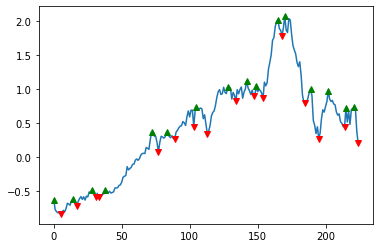

2009


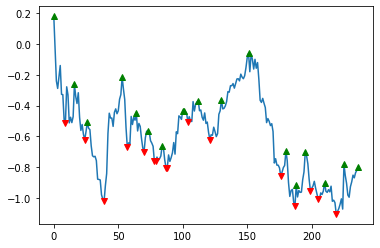

2010


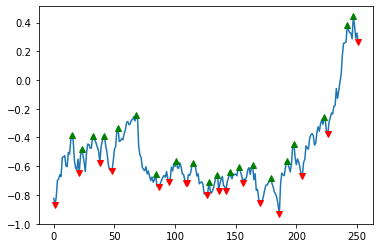

2011


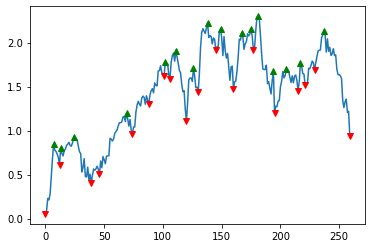

2012


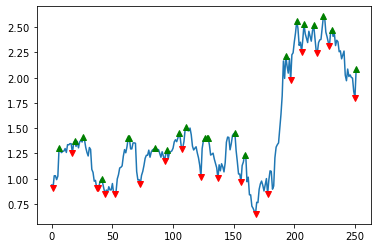

2013


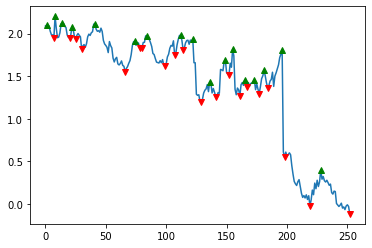

2014


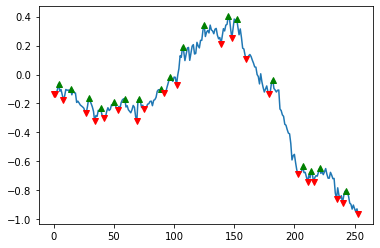

2015


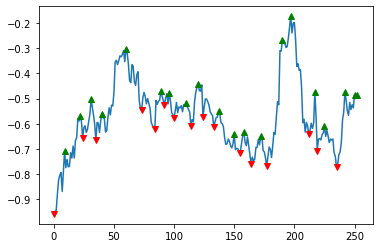

2016


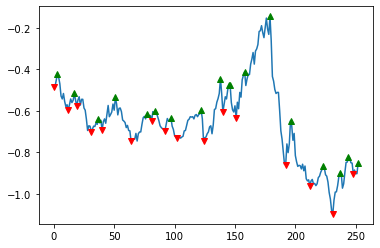

2017


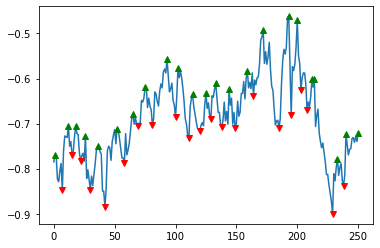

In [278]:
#plot the labeling
for key in data_lagged.keys():
    print(key)
    plt.plot(data_lagged[key]['Close'])
    for sell in sells[key]:
        plt.plot(sell, data_lagged[key]['Close'][sell], marker = '^', color = 'green')
    for buy in buys[key]:
        plt.plot(buy, data_lagged[key]['Close'][buy], marker = 'v', color = 'red')
    plt.show()

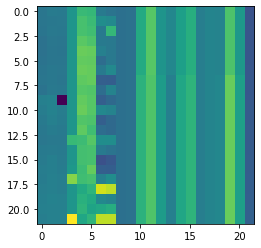

In [286]:
plt.imshow(matrices_dict[2010][0].iloc[:,1:])

In [181]:
subset_dict_label = label(subset_dict)
subset_dict_label[2008]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest,Labels
0,2007-10-01,-0.626041,-0.556610,-0.554022,-0.334083,0.607506,0.747199,0.077627,0.416007,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,-1.724370,0
1,2007-10-02,-0.765897,-0.608131,-0.685953,4.013997,0.517957,0.410835,1.812521,2.332146,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,-1.708974,0
2,2007-10-03,-0.795616,-0.722806,-0.730501,-0.334083,0.562732,0.218627,-0.624933,-0.722406,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,-1.693578,0
3,2007-10-04,-0.811350,-0.734440,-0.739068,-0.334083,0.920928,0.554991,-0.495891,-0.496977,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,-1.678181,0
4,2007-10-05,-0.811350,-0.774327,-0.749349,-0.334083,1.055252,1.179668,0.780187,0.765420,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,-1.662785,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2008-09-23,0.713081,0.674899,0.689900,-0.207132,0.920928,1.035512,0.077627,-0.046121,0.695806,...,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.662785,1
221,2008-09-24,0.732311,0.756335,0.727594,0.078508,0.786605,0.891355,0.077627,-0.271549,0.695806,...,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.678181,1
222,2008-09-25,0.699095,0.699829,0.727594,-0.334083,0.831379,0.699147,-0.782651,-1.049276,0.695806,...,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.693578,1
223,2008-09-29,0.382671,0.545267,0.419184,1.760612,0.428408,0.458887,0.780187,0.641435,0.695806,...,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.708974,1


In [182]:
subset_dict_label[2007]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest,Labels
0,2007-03-29,-0.449473,-0.438612,-0.386110,-0.302346,-0.153662,0.458887,-0.495891,-0.598420,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.718572,2
1,2007-03-30,-0.585832,-0.415344,-0.512901,0.364149,0.473183,0.603043,-0.782651,-0.722406,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.691507,1
2,2007-04-02,-0.708206,-0.684581,-0.643118,-0.334083,0.025437,-0.117737,-0.366850,-0.496977,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.664443,1
3,2007-04-03,-0.767645,-0.732778,-0.697947,0.681527,-0.422309,-0.838518,2.357363,2.005275,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.637379,1
4,2007-04-04,-0.685480,-0.659652,-0.617417,-0.334083,-1.093928,-1.078778,1.654803,1.543148,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.610315,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2007-09-24,-0.592825,-0.530019,-0.536888,-0.334083,1.055252,1.275772,0.493428,0.641435,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,1.610315,1
124,2007-09-25,-0.605062,-0.563258,-0.535175,0.015033,0.607506,0.362783,-0.366850,-0.372992,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,1.637379,1
125,2007-09-26,-0.582336,-0.559934,-0.552309,-0.334083,0.338859,0.122523,-1.485211,-0.271549,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,1.664443,1
126,2007-09-27,-0.500170,-0.470189,-0.509474,-0.334083,0.786605,0.554991,-0.782651,-0.598420,0.501137,...,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951,1.691507,2


In [183]:
all_labels_dict = {}
all_data_dict = {}

for key in tqdm(subset_dict_label.keys()):
    labels_list = []
    data_list = []
    for i in range(len(subset_dict_label[key])):
        if i<22:
            data_list.append(subset_dict_label[key].iloc[i-22:i,1:23])
        labels_list.append(subset_dict_label[key]['Labels'][i])
        data_list.append(subset_dict_label[key].iloc[i-22:i,1:23])
        labels_list.append(subset_dict_label[key]['Labels'][i])
    
    all_data_dict[key] = data_list
    all_labels_dict[key] = labels_list
    

100%|██████████| 12/12 [00:01<00:00,  8.11it/s]


In [184]:
del all_data_dict[2018]
del all_labels_dict[2018]
del all_data_dict[2007]
del all_labels_dict[2007]

In [185]:
#check NA values
for key in matrices_dict.keys():
    for i in range(len(matrices_dict[key])):
        if matrices_dict[key][i].isnull().values.any() == True:
            print(matrices_dict[key][i])


   Date  Close  High  Low  PRCP  TMAX  TMIN  WSF2  WSF5  Area Planted  ...  \
0   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
1   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
2   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
3   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
4   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
5   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
6   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
7   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
8   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
9   NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
10  NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN           NaN  ...   
11  NaT    NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN         

[22 rows x 23 columns]
         Date     Close      High       Low      PRCP      TMAX      TMIN  \
14 2007-04-19 -0.596321 -0.559934 -0.536888 -0.334083  0.025437 -0.117737   
15 2007-04-20 -0.683731 -3.059517 -0.619131 -0.334083  0.562732  0.266679   
16 2007-04-23 -0.727436 -0.689567 -0.661966 -0.334083  0.383633  0.506939   
17 2007-04-24 -0.662753 -0.638046 -0.601997  3.918784 -0.198436  0.362783   
18 2007-04-25 -0.570098 -0.551625 -0.524894  4.013997 -0.422309  0.122523   
19 2007-04-26 -0.659257 -0.626413 -0.583150  0.173722 -0.332760 -0.021633   
20 2007-04-27 -0.657508 -3.059517 -0.627698 -0.334083  0.383633  0.074471   
21 2007-04-30 -0.687228 -0.634722 -0.608850 -0.334083  1.144801  0.987460   
22 2007-05-01 -0.622544 -0.593174 -0.562589 -0.334083  0.786605  0.795251   
23 2007-05-02 -0.603314 -0.586526 -0.540315 -0.334083  0.517957  0.410835   
24 2007-05-03 -0.547372 -0.533343 -0.471779 -0.111919 -0.019338  0.410835   
25 2007-05-04 -0.538631 -0.515062 -0.495767  0.237197

          Date     Close      High       Low      PRCP      TMAX      TMIN  \
310 2008-07-17  1.209570  1.351316  1.236471  6.203907  1.234351  1.275772   
311 2008-07-21  0.915872  0.992333  0.926348  1.189332  0.965703  1.131616   
312 2008-07-22  0.805735  0.889292  0.838965 -0.334083  1.010478  1.131616   
313 2008-07-23  0.791750  0.862701  0.650492 -0.302346  0.831379  1.035512   
314 2008-07-24  0.802239  0.822814  0.773856  3.950522  0.562732  1.083564   
315 2008-07-28  0.865174  0.867686  0.862952  0.459362  1.055252  1.227720   
316 2008-07-29  0.949088  0.907573  0.835538 -0.334083  1.010478  1.371876   
317 2008-07-30  1.001534  0.962418  0.945195 -0.334083  1.100027  1.227720   
318 2008-07-31  0.903635  0.950784  0.933201 -0.334083  1.144801  1.323824   
319 2008-08-04  0.540009  0.739716  0.590523  0.618051  1.458223  1.323824   
320 2008-08-05  0.468333  0.580168  0.463732  0.364149  1.010478  1.179668   
321 2008-08-06  0.347707  0.462169  0.369496 -0.334083  0.920928

          Date     Close      High       Low      PRCP      TMAX      TMIN  \
337 2008-09-03  0.616930  0.656618  0.583669 -0.334083  0.159760  0.603043   
338 2008-09-04  0.636160  0.639998  0.624791  1.348021  0.204535  0.506939   
339 2008-09-08  0.522527  0.543605  0.542548  0.871954 -0.064113  0.218627   
340 2008-09-09  0.498052  0.490422  0.460305 -0.334083  0.294084  0.074471   
341 2008-09-10  0.449102  0.462169  0.492860 -0.302346  0.562732  0.554991   
342 2008-09-11  0.447354  0.437240  0.480866  0.015033  0.831379  0.987460   
343 2008-09-15  0.725318  0.940813  0.664199 -0.334083  0.294084  0.218627   
344 2008-09-16  0.517282  0.696505  0.569962 -0.334083  0.786605  0.314731   
345 2008-09-17  0.669376  0.743040  0.528841 -0.334083  0.965703  0.651095   
346 2008-09-18  0.482318  0.663266  0.515134 -0.334083  0.831379  0.843303   
347 2008-09-22  0.700843  0.802870  0.592236 -0.334083  0.741830  0.795251   
348 2008-09-23  0.713081  0.674899  0.689900 -0.207132  0.920928

[22 rows x 23 columns]
          Date     Close      High       Low      PRCP      TMAX      TMIN  \
522 2009-06-26 -0.517652 -0.488470 -0.473493 -0.334083  1.100027  1.516032   
523 2009-06-29 -0.568350 -0.503428 -0.500907 -0.334083  1.100027  0.891355   
524 2009-06-30 -0.772890 -0.521709 -0.761342 -0.334083  0.786605  0.939407   
525 2009-07-01 -0.744918 -0.702863 -0.725361 -0.334083  0.920928  0.939407   
526 2009-07-02 -0.786875 -0.716158 -0.732215 -0.334083  1.010478  0.891355   
527 2009-07-03 -0.786875 -3.059517 -3.076133  0.649789  0.965703  1.083564   
528 2009-07-06 -0.804357 -0.754383 -0.752775 -0.334083  1.100027  1.083564   
529 2009-07-07 -0.858551 -0.674609 -0.780190 -0.175394  1.144801  1.131616   
530 2009-07-08 -0.832328 -0.762693 -0.778476  1.221070  0.831379  1.035512   
531 2009-07-09 -0.802609 -0.762693 -0.754489 -0.016705  0.920928  0.939407   
532 2009-07-10 -0.788623 -0.747736 -0.766482 -0.302346  1.100027  1.179668   
533 2009-07-13 -0.694221 -0.689567 -0.752

[22 rows x 23 columns]
          Date     Close      High       Low      PRCP      TMAX      TMIN  \
799 2010-08-02 -0.473947 -0.372133 -0.408384  0.618051  1.055252  1.419928   
800 2010-08-03 -0.480940 -0.436950 -0.435798  4.267900  1.323900  1.467980   
801 2010-08-04 -0.405768 -0.387091 -0.420378  0.205459  1.100027  1.419928   
802 2010-08-05 -0.383041 -0.234191 -0.365549 -0.334083  1.100027  1.275772   
803 2010-08-06 -0.372552 -0.345542 -0.389536 -0.334083  1.100027  1.179668   
804 2010-08-09 -0.386537 -0.327260 -0.327854  4.172686  1.234351  1.419928   
805 2010-08-10 -0.452969 -0.382105 -0.384396  5.696102  1.413449  1.419928   
806 2010-08-11 -0.438983 -0.397063 -0.399817  2.077991  1.458223  1.371876   
807 2010-08-12 -0.363811 -0.307317 -0.370689 -0.334083  1.458223  1.660188   
808 2010-08-13 -0.325350 -0.308979 -0.293587 -0.270608  1.323900  1.564084   
809 2010-08-16 -0.356818 -0.284050 -0.295300 -0.334083  1.100027  0.939407   
810 2010-08-17 -0.304372 -0.292359 -0.291

           Date     Close      High       Low       PRCP      TMAX      TMIN  \
1022 2011-06-09  2.288209  2.212209  2.129148  14.043147  0.428408  0.747199   
1023 2011-06-10  2.298699  2.257082  2.250798   2.236680  0.428408  0.939407   
1024 2011-06-13  2.267231  2.208885  2.250798   1.824088  0.473183  0.747199   
1025 2011-06-14  2.078425  2.122464  2.081173  -0.080181  0.517957  0.987460   
1026 2011-06-15  1.870389  2.007789  1.896127   0.491100  0.876154  1.035512   
1027 2011-06-16  1.700814  1.783425  1.712794  -0.334083  0.965703  0.795251   
1028 2011-06-17  1.692073  1.690355  1.661392  -0.302346  1.100027  1.227720   
1029 2011-06-20  1.693821  1.645482  1.690520   7.981224  0.965703  1.035512   
1030 2011-06-21  1.742771  1.721932  1.741921  -0.143657  0.786605  1.035512   
1031 2011-06-22  1.532987  1.687031  1.570582  -0.111919  0.249310  0.939407   
1032 2011-06-23  1.553965  1.480948  1.303293  -0.334083  0.383633  0.891355   
1033 2011-06-24  1.480541  1.579004  1.5

           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1182 2012-01-27  1.282994  1.210050  1.248465 -0.302346 -1.004379 -0.742414   
1183 2012-01-30  1.213066  1.213373  1.224477 -0.334083  0.159760 -0.309946   
1184 2012-01-31  1.263764  1.208388  1.248465 -0.334083 -0.019338 -0.213841   
1185 2012-02-01  1.284742  1.261570  1.296440 -0.334083 -0.064113 -0.646310   
1186 2012-02-02  1.291735  1.241627  1.270739 -0.334083 -0.287985 -0.790466   
1187 2012-02-03  1.302224  1.238303  1.296440 -0.238870 -0.959604 -0.406050   
1188 2012-02-06  1.300476  1.251598  1.305007 -0.334083 -1.228252 -0.982674   
1189 2012-02-07  1.286490  1.228331  1.305007 -0.302346 -1.183477 -0.886570   
1190 2012-02-08  1.288239  1.253260  1.255319 -0.334083 -1.452125 -1.367090   
1191 2012-02-09  1.249778  1.274866  1.260459 -0.334083 -1.228252 -1.559298   
1192 2012-02-10  1.213066  1.186782  1.229618 -0.334083 -1.362576 -1.511246   
1193 2012-02-13  1.267260  1.218359  1.260459  0.110

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1300 2012-07-16  2.227022  2.127450  2.058899 -0.334083  1.637322  1.467980   
1301 2012-07-17  2.246253  2.235477  2.180549 -0.334083  1.726871  1.660188   
1302 2012-07-18  2.354641  2.238801  2.156562 -0.334083  1.861195  1.612136   
1303 2012-07-19  2.443799  2.370095  2.339895 -0.334083  1.502998  1.419928   
1304 2012-07-20  2.560929  2.449869  2.403290 -0.334083  1.279125  1.275772   
1305 2012-07-23  2.487504  2.418292  2.374163 -0.334083  1.950744  1.660188   
1306 2012-07-24  2.319677  2.361786  2.228524 -0.334083  1.816420  1.804344   
1307 2012-07-25  2.351145  2.296969  2.281640  1.252807  1.995519  1.467980   
1308 2012-07-26  2.258490  2.255420  2.243945 -0.207132  1.502998  1.419928   
1309 2012-07-27  2.379116  2.265392  2.245658 -0.334083  1.010478  1.179668   
1310 2012-07-30  2.529461  2.411644  2.405004 -0.334083  1.502998  1.467980   
1311 2012-07-31  2.435058  2.

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1364 2012-10-15  1.950807  1.936325  1.944102 -0.334083  0.383633 -0.069685   
1365 2012-10-16  1.957799  1.894776  1.962949 -0.334083  0.697055  0.458887   
1366 2012-10-17  2.008497  1.901424  1.969802 -0.143657  0.114986  0.266679   
1367 2012-10-18  2.115137  2.006127  2.026344  0.998905 -0.467084  0.074471   
1368 2012-10-19  2.120382  2.052662  2.120581 -0.111919 -0.556633  0.026419   
1369 2012-10-22  2.118634  2.039366  2.124008  0.586313  0.517957  1.035512   
1370 2012-10-23  2.081922  2.009451  2.060612 -0.270608  0.607506  0.891355   
1371 2012-10-24  2.071432  2.016099  2.074319 -0.334083  0.697055  0.699147   
1372 2012-10-25  1.984022  1.976212  2.000643  0.015033 -0.198436 -0.165789   
1373 2012-10-26  1.954303  1.891452  1.974943 -0.334083 -0.735731 -0.454102   
1374 2012-10-29  1.949058  1.899762  1.944102 -0.334083 -0.422309 -0.309946   
1375 2012-10-30  1.982274  1.

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1560 2013-07-25  0.263793  0.335860  0.297533 -0.334083  1.144801  0.939407   
1561 2013-07-26  0.235822  0.262734  0.287253  0.205459  0.831379  0.939407   
1562 2013-07-29  0.216592  0.247777  0.270119 -0.334083  0.607506  0.699147   
1563 2013-07-30  0.260297  0.246115  0.278686  0.268935  0.517957  1.035512   
1564 2013-07-31  0.284772  0.261072  0.302673 -0.334083  1.100027  1.083564   
1565 2013-08-01  0.204354  0.262734  0.258125 -0.334083  1.234351  0.987460   
1566 2013-08-02  0.123937  0.192932  0.181023 -0.334083  1.055252  1.227720   
1567 2013-08-05  0.076736  0.098200  0.114200 -0.334083  1.055252  1.083564   
1568 2013-08-06  0.097714  0.101524  0.114200  0.459362  1.368674  1.323824   
1569 2013-08-07  0.069743  0.106510  0.126194 -0.334083  1.010478  1.275772   
1570 2013-08-08  0.106455  0.101524  0.131334 -0.334083  0.965703  1.035512   
1571 2013-08-09  0.052261  0.

           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2443 2017-01-20 -0.619048 -0.599821 -0.574583 -0.143657 -0.825281 -0.309946   
2444 2017-01-23 -0.620796 -0.599821 -0.557449 -0.334083 -1.183477 -0.502154   
2445 2017-01-24 -0.664501 -0.593174 -0.593430 -0.111919 -1.183477 -0.550206   
2446 2017-01-25 -0.643523 -0.621427 -0.601997  0.141984 -1.183477 -0.694362   
2447 2017-01-26 -0.661005 -0.621427 -0.595143 -0.334083 -1.407350 -0.934622   
2448 2017-01-27 -0.669746 -0.638046 -0.605424 -0.334083 -1.317801 -1.174882   
2449 2017-01-30 -0.702962 -0.654666 -0.637978 -0.334083 -0.422309 -0.646310   
2450 2017-01-31 -0.688976 -0.657990 -0.624271 -0.334083 -0.780506 -0.309946   
2451 2017-02-01 -0.629537 -0.609793 -0.622558 -0.334083 -1.093928 -0.982674   
2452 2017-02-02 -0.634782 -0.601483 -0.566016 -0.334083 -1.631223 -1.319038   
2453 2017-02-03 -0.650516 -0.614779 -0.581436 -0.334083 -1.362576 -1.222934   
2454 2017-02-06 -0.661005 -0.608131 -0.591717 -0.334

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2519 2017-05-10 -0.650516 -0.633061 -0.620844  4.553540  0.428408  0.795251   
2520 2017-05-11 -0.683731 -0.638046 -0.607137 -0.334083  0.562732  0.603043   
2521 2017-05-12 -0.674990 -0.653004 -0.608850 -0.334083  0.697055  0.266679   
2522 2017-05-15 -0.633034 -0.588188 -0.559162 -0.334083  1.323900  1.179668   
2523 2017-05-16 -0.633034 -0.608131 -0.572869  1.538448  1.234351  1.035512   
2524 2017-05-17 -0.606811 -0.584864 -0.566016  0.935429  0.876154  0.939407   
2525 2017-05-18 -0.645271 -0.589850 -0.579723  1.855826  0.249310  0.506939   
2526 2017-05-19 -0.599818 -0.579878 -0.567729  1.411496 -0.332760  0.362783   
2527 2017-05-22 -0.582336 -0.549963 -0.528321 -0.175394  0.473183  0.266679   
2528 2017-05-23 -0.620796 -0.561596 -0.547168 -0.334083  0.114986  0.410835   
2529 2017-05-24 -0.608559 -0.589850 -0.548882  0.173722  0.204535  0.410835   
2530 2017-05-25 -0.622544 -0.

           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2727 2018-03-08 -0.507163 -0.495118 -0.485486 -0.334083 -1.228252 -1.126830   
2728 2018-03-09 -0.526393 -0.498442 -0.454645 -0.302346 -1.004379 -0.886570   
2729 2018-03-12 -0.517652 -0.505090 -0.468352 -0.334083 -0.646182 -0.598258   
2730 2018-03-13 -0.508911 -0.475175 -0.447792 -0.334083 -0.825281 -0.790466   
2731 2018-03-14 -0.522897 -0.490132 -0.442652 -0.334083  0.159760 -1.030726   
2732 2018-03-15 -0.500170 -0.461879 -0.434085 -0.334083 -0.153662 -0.550206   
2733 2018-03-16 -0.528142 -0.483484 -0.454645  0.649789 -1.004379 -0.454102   
2734 2018-03-19 -0.582336 -0.520047 -0.507760 -0.334083 -0.332760 -0.406050   
2735 2018-03-20 -0.585832 -0.553287 -0.518041 -0.334083 -0.870055 -0.502154   
2736 2018-03-21 -0.582336 -0.561596 -0.514614 -0.334083 -0.690957 -0.694362   
2737 2018-03-22 -0.575343 -0.549963 -0.512901 -0.175394 -0.511858 -0.502154   
2738 2018-03-23 -0.566602 -0.544977 -0.545455 -0.143

           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2752 2018-04-13 -0.503667 -0.471851 -0.437511  0.491100  0.025437 -0.117737   
2753 2018-04-16 -0.529890 -0.491794 -0.458072 -0.334083 -1.049153 -0.934622   
2754 2018-04-17 -0.545624 -0.503428 -0.473493 -0.334083 -0.243211 -0.790466   
2755 2018-04-18 -0.526393 -0.510076 -0.471779 -0.207132 -0.959604 -0.502154   
2756 2018-04-19 -0.533386 -0.510076 -0.466639 -0.334083 -0.332760 -0.550206   
2757 2018-04-20 -0.571847 -0.521709 -0.497480 -0.334083 -0.019338 -0.454102   
2758 2018-04-23 -0.557861 -0.538329 -0.497480 -0.334083  0.562732  0.266679   
2759 2018-04-24 -0.538631 -0.523371 -0.492340 -0.334083  0.607506  0.218627   
2760 2018-04-25 -0.501919 -0.485146 -0.468352 -0.334083  0.249310  0.266679   
2761 2018-04-26 -0.505415 -0.486808 -0.444365 -0.334083  0.562732 -0.165789   
2762 2018-04-27 -0.480940 -0.463541 -0.435798 -0.334083  0.741830 -0.069685   
2763 2018-04-30 -0.459962 -0.428640 -0.399817 -0.334

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2786 2018-06-01 -0.466955 -0.420330 -0.398103 -0.334083  1.547773  1.131616   
2787 2018-06-04 -0.542127 -0.468527 -0.468352 -0.334083  0.920928  0.603043   
2788 2018-06-05 -0.521149 -0.498442 -0.471779 -0.334083  1.234351  0.891355   
2789 2018-06-06 -0.559609 -0.490132 -0.485486  2.236680  1.368674  0.987460   
2790 2018-06-07 -0.573595 -0.520047 -0.511187 -0.334083  1.144801  1.131616   
2791 2018-06-08 -0.563106 -0.539991 -0.516327 -0.334083  1.234351  1.419928   
2792 2018-06-11 -0.636530 -0.539991 -0.562589  1.728875  0.876154  1.131616   
2793 2018-06-12 -0.564854 -0.536667 -0.559162 -0.207132  1.100027  1.227720   
2794 2018-06-13 -0.575343 -0.535005 -0.518041 -0.334083  0.876154  1.083564   
2795 2018-06-14 -0.666249 -0.568244 -0.591717  1.506710  0.876154  0.939407   
2796 2018-06-15 -0.678487 -0.611455 -0.641405 -0.334083  1.413449  1.419928   
2797 2018-06-18 -0.715199 -0.

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2814 2018-07-12 -0.851559 -0.794270 -0.816171 -0.334083  1.547773  1.467980   
2815 2018-07-13 -0.895264 -0.849115 -0.799037 -0.016705  1.502998  1.467980   
2816 2018-07-16 -0.814846 -0.761031 -0.754489 -0.334083  1.144801  1.419928   
2817 2018-07-17 -0.783379 -0.741088 -0.716794 -0.334083  1.055252  1.083564   
2818 2018-07-18 -0.776386 -0.739426 -0.704800 -0.334083  1.144801  1.227720   
2819 2018-07-19 -0.748415 -0.719482 -0.711654 -0.334083  1.234351  1.275772   
2820 2018-07-20 -0.720444 -0.694553 -0.679100 -0.334083  0.920928  1.179668   
2821 2018-07-23 -0.706458 -0.676271 -0.646545 -0.334083  1.144801  1.035512   
2822 2018-07-24 -0.743170 -0.689567 -0.667106 -0.334083  1.100027  1.083564   
2823 2018-07-25 -0.692472 -0.666300 -0.663679 -0.334083  1.100027  1.035512   
2824 2018-07-26 -0.676739 -0.628075 -0.607137 -0.334083  0.965703  0.939407   
2825 2018-07-27 -0.673242 -0.

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2843 2018-08-22 -0.739674 -0.671286 -0.661966 -0.334083  0.786605  0.603043   
2844 2018-08-23 -0.779882 -0.699539 -0.703087 -0.334083  0.741830  0.747199   
2845 2018-08-24 -0.767645 -0.732778 -0.703087 -0.111919  0.965703  1.035512   
2846 2018-08-27 -0.779882 -0.741088 -0.725361  1.697137  1.323900  1.419928   
2847 2018-08-28 -0.820091 -0.747736 -0.740782 -0.302346  0.965703  0.939407   
2848 2018-08-29 -0.818343 -0.772665 -0.744208 -0.334083  0.652281  0.699147   
2849 2018-08-30 -0.820091 -0.772665 -0.742495 -0.334083  0.786605  0.747199   
2850 2018-08-31 -0.750163 -0.719482 -0.740782  2.490582  1.010478  1.179668   
2851 2018-09-04 -0.725688 -0.697877 -0.696233  1.379759  1.144801  1.371876   
2852 2018-09-05 -0.744918 -0.692891 -0.670533  3.061863  0.607506  1.179668   
2853 2018-09-06 -0.732681 -0.702863 -0.672246 -0.334083  0.517957  0.987460   
2854 2018-09-07 -0.727436 -0.

In [210]:
#deleted 2007 and 2018
del matrices_dict[2018]
del matrices_dict[2007]

In [231]:
pd.read_csv('ResNet18-2008.csv')

,Date,Confidence
0,-0.007041,0.956668
1,0.105614,0.999829
2,0.161941,0.972813
3,0.218268,0.996597
4,0.316841,0.992701
...,...,...
56,1.640533,1.000000
57,1.668697,0.992564
58,1.682779,1.000000
59,1.696861,0.999965


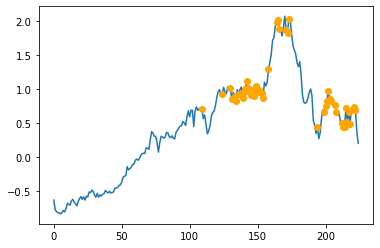

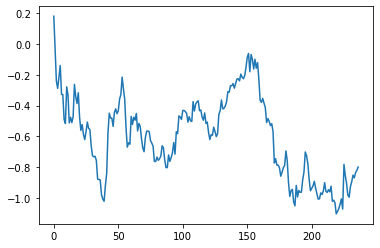

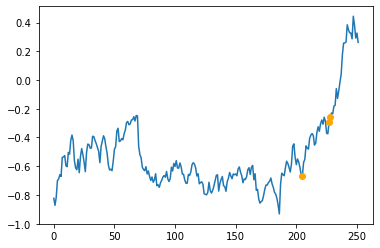

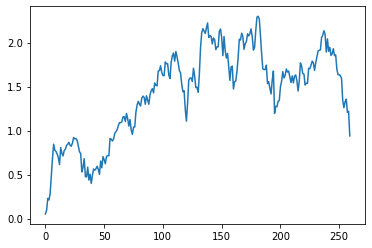

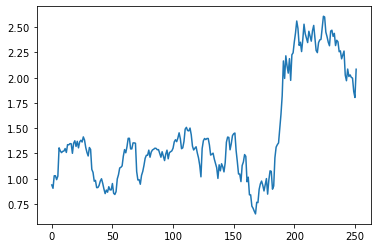

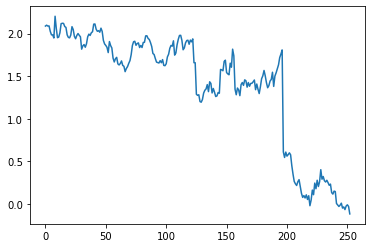

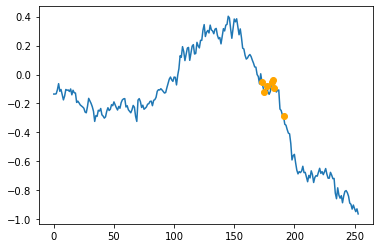

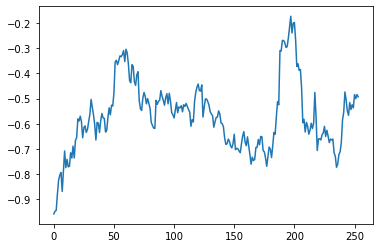

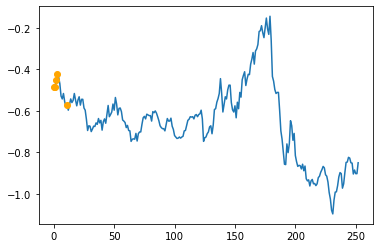

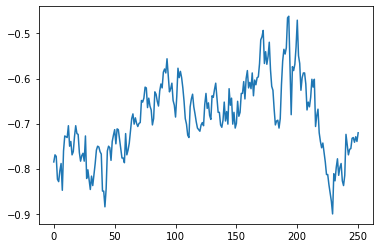

In [270]:
for key in matrices_dict.keys():
    file_name = str('ResNet18-' + str(key) + '.csv')
    
    total = reduce(lambda x,y: x.append(y), matrices_dict[key])
    total = total.drop_duplicates().iloc[21:,:]
    total = total.reset_index(drop=True)
    #print(list(total['Days Since Harvest']))
    try:
        sells = list(pd.read_csv(file_name)['Date'])
        #print(sells)
   
    except:
        sells = [0]
        
    plt.plot(total['Close'])
    
    sell_days = list(total['Days Since Harvest']).index(float(sell))
    sell_prices = total['Close'][list(total['Days Since Harvest']).index(float(sell))]
    
    for sell in sells:
        try:
            plt.plot(sell_days, sell_prices, marker = 'o', color = 'orange')
        except:
            pass
    plt.show()

In [269]:
 -0.204186538351631 == -0.204186538351631

list(total['Days Since Harvest'])[87] == float(sells[0])


list(total['Days Since Harvest'])[0] == float(sells[0])

#sells_2008 = [-1.4670131763465755,-1.4546853345285369,-1.4423574927104985,-1.4300296508924601,-1.4177018090744216,-1.4053739672563832,-1.3930461254383446,-1.3807182836203062,-1.3683904418022679,-1.3560625999842293,-1.343734758166191,-1.3314069163481526,-1.319079074530114,-1.3067512327120756,-1.294423390894037,-1.2820955490759987,-1.1958006563497294,-1.1095057636234604,-1.0848500799873835,-1.072522238169345,-1.0601943963513065,-1.0355387127152298,-1.0232108708971912,-1.0108830290791528,-0.9985551872611144,-0.9862273454430759,-0.9738995036250374,-0.9369159781709221,-0.9245881363528836,-0.8999324527168068,-0.8876046108987683,-0.8629489272626915,-0.8013097181724992,0.30819604545096124,0.32052388726899966,0.35750741272311504,0.38216309635919193,0.39449093817723035,0.41914662181330725,0.44380230544938415,0.4561301472674226,0.46845798908546105,0.49311367272153794,0.5177693563576149,0.5424250399936917,0.5547528818117302,0.5670807236297687,0.5794085654478071,0.6410477745379993,0.6533756163560378,0.6657034581740763,0.6780312999921146,0.6903591418101531,0.7026869836281916,0.7150148254462301,0.7643261927183839,0.7766540345364222,0.7889818763544607,0.8013097181724992,0.8136375599905377,0.825965401808576,0.8382932436266145,0.850621085444653,0.8629489272626915,0.8752767690807298,0.8876046108987683,0.8999324527168068,0.9122602945348453,0.9245881363528836,0.9369159781709221,0.9492438199889606,0.961571661806999,0.9738995036250374,0.9862273454430759,1.0108830290791528,1.0232108708971912,1.1218336054414988,1.3807182836203062,1.3930461254383446,1.4053739672563832,1.4300296508924601,1.4423574927104985,1.4916688599826522,1.5286523854367677,1.540980227254806,1.5902915945269598,1.6149472781630367,1.6272751199810753,1.6396029617991137,1.725897854525383]

False

In [225]:
sells

['-1.4670131763465755',
 '-1.4546853345285369',
 '-1.4423574927104985',
 '-1.4300296508924601',
 '-1.4177018090744216',
 '-1.4053739672563832',
 '-1.3930461254383446',
 '-1.3807182836203062',
 '-1.3683904418022679',
 '-1.3560625999842293',
 '-1.343734758166191',
 '-1.3314069163481526',
 '-1.319079074530114',
 '-1.3067512327120756',
 '-1.294423390894037',
 '-1.2820955490759987',
 '-1.1958006563497294',
 '-1.1095057636234604',
 '-1.0848500799873835',
 '-1.072522238169345',
 '-1.0601943963513065',
 '-1.0355387127152298',
 '-1.0232108708971912',
 '-1.0108830290791528',
 '-0.9985551872611144',
 '-0.9862273454430759',
 '-0.9738995036250374',
 '-0.9369159781709221',
 '-0.9245881363528836',
 '-0.8999324527168068',
 '-0.8876046108987683',
 '-0.8629489272626915',
 '-0.8013097181724992',
 '0.30819604545096124',
 '0.32052388726899966',
 '0.35750741272311504',
 '0.38216309635919193',
 '0.39449093817723035',
 '0.41914662181330725',
 '0.44380230544938415',
 '0.4561301472674226',
 '0.46845798908546105

In [194]:
from functools import reduce
total_2008 = reduce(lambda x,y: x.append(y), matrices_dict[2011])
print(len(total_2008))
total_2008 = total_2008.drop_duplicates().iloc[21:,:]
total_2008 = total_2008.reset_index(drop=True)
total_2008

5720


,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest
0,2010-10-01,0.052261,0.229495,0.115914,-0.334083,0.786605,0.314731,0.780187,0.641435,-0.889353,...,-0.011217,-0.801289,-0.056760,0.096429,0.017199,0.004376,0.074291,0.698712,0.358543,-1.467013
1,2010-10-04,0.092470,0.089891,0.037098,-0.334083,0.159760,-0.165789,-0.911692,-0.722406,-0.889353,...,-0.011217,-0.801289,-0.056760,0.096429,0.017199,0.004376,0.074291,0.698712,0.358543,-1.454685
2,2010-10-05,0.228829,0.221185,0.109060,-0.334083,0.473183,-0.021633,-0.782651,-0.722406,-0.889353,...,-0.011217,-0.801289,-0.056760,0.096429,0.017199,0.004376,0.074291,0.698712,0.358543,-1.442357
3,2010-10-06,0.211347,0.237805,0.263265,-0.334083,0.920928,0.314731,-0.911692,-0.947834,-0.889353,...,-0.011217,-0.801289,-0.056760,0.096429,0.017199,0.004376,0.074291,0.698712,0.358543,-1.430030
4,2010-10-07,0.279527,0.281016,0.266692,-0.334083,0.741830,0.026419,-1.657266,-1.601576,-0.889353,...,-0.011217,-0.801289,-0.056760,0.096429,0.017199,0.004376,0.074291,0.698712,0.358543,-1.417702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2011-09-26,1.326699,1.283176,1.241611,-0.270608,0.294084,0.410835,1.239002,1.092291,-0.805924,...,-0.636490,-0.199199,-0.346039,-0.500475,0.482600,0.462547,0.200502,-0.000681,0.161064,1.676586
256,2011-09-27,1.356418,1.369597,1.351268,-0.334083,0.473183,0.554991,-0.911692,-1.049276,-0.805924,...,-0.636490,-0.199199,-0.346039,-0.500475,0.482600,0.462547,0.200502,-0.000681,0.161064,1.688914
257,2011-09-28,1.206073,1.266556,1.233044,-0.334083,0.876154,0.747199,-1.485211,-1.150719,-0.805924,...,-0.636490,-0.199199,-0.346039,-0.500475,0.482600,0.462547,0.200502,-0.000681,0.161064,1.701242
258,2011-09-29,1.218311,1.183458,1.193636,-0.334083,0.652281,0.699147,2.644122,2.456132,-0.805924,...,-0.636490,-0.199199,-0.346039,-0.500475,0.482600,0.462547,0.200502,-0.000681,0.161064,1.713570


In [127]:
list(total_2008['Days Since Harvest']).index(sells_2008[0])

21

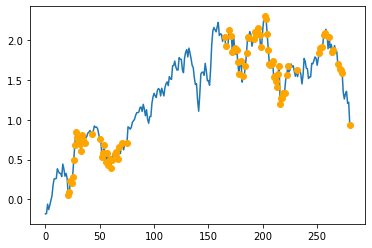

In [128]:
plt.plot(total_2008['Close'])
for sell in sells_2008:
    plt.plot(list(total_2008['Days Since Harvest']).index(sell), total_2008['Close'][list(total_2008['Days Since Harvest']).index(sell)], marker = 'o', color = 'orange')
plt.show()

In [74]:
file_to_write = open("data_in_matrix.pkl", "wb")
pickle.dump(matrices_dict, file_to_write)

In [193]:
#all_data_dict[2008][0]
file_to_write = open("data_in_matrix.pkl", "wb")
pickle.dump(all_data_dict, file_to_write)

In [194]:
file_to_write = open("label_for_matrix.pkl", "wb")
pickle.dump(all_labels_dict, file_to_write)

In [195]:
file_to_write = open("data_lagged.pkl", "wb")
pickle.dump(data_lagged, file_to_write)

In [196]:
file_to_write = open("labels_lagged.pkl", "wb")
pickle.dump(label_lagged, file_to_write)

In [178]:
test = labeled_dict_lagged
file_to_write = open("data_w_day.pickle", "wb")
pickle.dump(test, file_to_write)


In [ ]:
f = open("sample.pkl", "w")
pickle.dump(labeled_dict_lagged, f)

In [117]:
f = open('data.pickle', "rb")
pickle.load(f)

{2007:           Date     Close      High       Low      PRCP      TMAX      TMIN  \
 0   2007-03-29 -0.449473 -0.438612 -0.386110 -0.302346 -0.153662  0.458887   
 1   2007-03-30 -0.585832 -0.415344 -0.512901  0.364149  0.473183  0.603043   
 2   2007-04-02 -0.708206 -0.684581 -0.643118 -0.334083  0.025437 -0.117737   
 3   2007-04-03 -0.767645 -0.732778 -0.697947  0.681527 -0.422309 -0.838518   
 4   2007-04-04 -0.685480 -0.659652 -0.617417 -0.334083 -1.093928 -1.078778   
 ..         ...       ...       ...       ...       ...       ...       ...   
 126 2007-09-24 -0.592825 -0.530019 -0.536888 -0.334083  1.055252  1.275772   
 127 2007-09-25 -0.605062 -0.563258 -0.535175  0.015033  0.607506  0.362783   
 128 2007-09-26 -0.582336 -0.559934 -0.552309 -0.334083  0.338859  0.122523   
 129 2007-09-27 -0.500170 -0.470189 -0.509474 -0.334083  0.786605  0.554991   
 130 2007-09-28 -0.596321 -0.483484 -0.540315 -0.334083  0.517957  0.170575   
 
          WSF2      WSF5  Area Planted  ... 

In [33]:
for key in corn_year_dict_new.keys():
    labels = []
    sell_threshold = np.sort(corn_year_dict_new[key]['Close'])[-20]
    buy_threshold = np.sort(corn_year_dict_new[key]['Close'])[20]
    for i in range(len(corn_year_dict_new[key])):
        if corn_year_dict_new[key]['Close'][i] >= sell_threshold:
            labels.append(1)
        elif corn_year_dict_new[key]['Close'][i] <= buy_threshold:
            labels.append(-1)
        else:
            labels.append(0)

    corn_year_dict_new[key]['Labels'] = labels
        

In [34]:
corn_year_dict_new[2007]

,Open,Close,High,Low,Volume,Date,Labels
0,3.9500,3.9400,3.9425,3.9250,NaN,2007-03-29,1
1,0.0000,3.7450,3.9775,3.7400,NaN,2007-03-30,0
2,3.5600,3.5700,3.5725,3.5500,NaN,2007-04-02,0
3,3.4700,3.4850,3.5000,3.4700,NaN,2007-04-03,0
4,3.5975,3.6025,3.6100,3.5875,NaN,2007-04-04,0
...,...,...,...,...,...,...,...
123,3.7525,3.7350,3.8050,3.7050,89555.0,2007-09-24,0
124,3.7250,3.7175,3.7550,3.7075,65812.0,2007-09-25,0
125,3.7075,3.7500,3.7600,3.6825,67962.0,2007-09-26,0
126,3.7600,3.8675,3.8950,3.7450,107139.0,2007-09-27,1


In [35]:
weather['Date'] = pd.to_datetime(weather['DATE'])

In [36]:
weather_subset = weather[weather['STATION'] == 'USW00014933']

In [37]:
for key in corn_year_dict_new.keys():
    corn_year_dict_new[key] = corn_year_dict_new[key].merge(weather_subset, how = 'left', on = 'Date' )
    corn_year_dict_new[key] = corn_year_dict_new[key].merge(normalized_monthly_corn_data, how = 'left', on = 'Date')

In [38]:
list(corn_year_dict_new[2008].columns)

['Open',
 'Close',
 'High',
 'Low',
 'Volume',
 'Date',
 'Labels',
 'STATION',
 'LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'DATE',
 'PRCP',
 'TMAX',
 'TMIN',
 'WDMV',
 'WSF2',
 'WSF5',
 'Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use',
 'Ending Stocks',
 'World BeginningStocks',
 'World Production',
 'World Imports',
 'World DomesticFeed',
 'World DomesticTotal',
 'World Exports',
 'World EndingStocks',
 'United States BeginningStocks',
 'United States Production',
 'United States Imports',
 'United States DomesticFeed',
 'United States DomesticTotal',
 'United States Exports',
 'United States EndingStocks',
 'Argentina BeginningStocks',
 'Argentina Production',
 'Argentina Imports',
 'Argentina DomesticFeed',
 'Argentina DomesticTotal',
 'Argentina Exports',
 'Argentina EndingStocks',
 'Brazil BeginningStocks',
 'Brazil Production',
 'Brazil 

In [45]:
from statsmodels.tsa.stattools import adfuller


In [46]:
test_result=adfuller(corn_year_dict_new[2008]['Close'])


In [47]:
test_result

(-1.5048946162363042,
 0.5310886676066703,
 0,
 224,
 {'1%': -3.459884913337196,
  '5%': -2.8745310704320794,
  '10%': -2.573693840082908},
 -225.26366483586656)

In [49]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(corn_year_dict_new[2008]['Close'])

ADF Test Statistic : -1.5048946162363042
p-value : 0.5310886676066703
#Lags Used : 0
Number of Observations : 224
weak evidence against null hypothesis,indicating it is non-stationary 


In [68]:
first_diff = corn_year_dict_new[2008]['Close'] - corn_year_dict_new[2008]['Close'].shift(5)
first_diff = first_diff[5:]

In [69]:
adfuller_test(first_diff)

ADF Test Statistic : -2.8530472623053944
p-value : 0.051086741470862465
#Lags Used : 15
Number of Observations : 204
weak evidence against null hypothesis,indicating it is non-stationary 


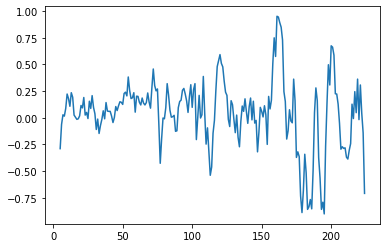

In [70]:
plt.plot(first_diff)

In [92]:
def generate_time_lags(df,col, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n, col}"] = df_n[col].shift(n)
    #df_n = df_n.iloc[n_lags:]
    return df_n

In [93]:
test_2008 = corn_year_dict_new[2008][['Labels', 'Date', 'Close', 'High', 'Low','PRCP',
 'TMAX',
 'TMIN',
 'WSF2',
 'WSF5','Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use']]

In [94]:
test_2008

,Labels,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,...,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use
0,-1,2007-10-01,3.6875,3.7650,3.6800,0.00,75.0,58.0,21.0,30.0,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
1,-1,2007-10-02,3.4875,3.6875,3.4875,1.37,73.0,51.0,33.1,47.0,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
2,-1,2007-10-03,3.4450,3.5150,3.4225,0.00,74.0,47.0,16.1,19.9,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
3,-1,2007-10-04,3.4225,3.4975,3.4100,0.00,82.0,54.0,17.0,21.9,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
4,-1,2007-10-05,3.4225,3.4375,3.3950,0.00,85.0,67.0,25.9,33.1,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0,2008-09-23,5.6025,5.6175,5.4950,0.04,82.0,64.0,21.0,25.9,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
221,0,2008-09-24,5.6300,5.7400,5.5500,0.13,79.0,61.0,21.0,23.9,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
222,0,2008-09-25,5.5825,5.6550,5.5500,0.00,80.0,57.0,15.0,17.0,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
223,0,2008-09-29,5.1300,5.4225,5.1000,0.66,71.0,52.0,25.9,32.0,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097


In [98]:
df_generated = test_2008
for column in list(test_2008.keys()):
    print(column)
    df_generated = generate_time_lags(df_generated, column, 20)
df_generated[]


Labels
Date
Close
High
Low
PRCP
TMAX
TMIN
WSF2
WSF5
Area Planted
Area Harvested
Yield
Beginning Stocks
Production
Imports
Total Supply
Feed and Residual
FSI
Ethanol
Total Domestic
Exports
Total Use


,Labels,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,...,"lag(11, 'Total Use')","lag(12, 'Total Use')","lag(13, 'Total Use')","lag(14, 'Total Use')","lag(15, 'Total Use')","lag(16, 'Total Use')","lag(17, 'Total Use')","lag(18, 'Total Use')","lag(19, 'Total Use')","lag(20, 'Total Use')"
0,-1,2007-10-01,3.6875,3.7650,3.6800,0.00,75.0,58.0,21.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,2007-10-02,3.4875,3.6875,3.4875,1.37,73.0,51.0,33.1,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,2007-10-03,3.4450,3.5150,3.4225,0.00,74.0,47.0,16.1,19.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,2007-10-04,3.4225,3.4975,3.4100,0.00,82.0,54.0,17.0,21.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1,2007-10-05,3.4225,3.4375,3.3950,0.00,85.0,67.0,25.9,33.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0,2008-09-23,5.6025,5.6175,5.4950,0.04,82.0,64.0,21.0,25.9,...,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097
221,0,2008-09-24,5.6300,5.7400,5.5500,0.13,79.0,61.0,21.0,23.9,...,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097
222,0,2008-09-25,5.5825,5.6550,5.5500,0.00,80.0,57.0,15.0,17.0,...,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097
223,0,2008-09-29,5.1300,5.4225,5.1000,0.66,71.0,52.0,25.9,32.0,...,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097


In [89]:
list(test_2008.keys())

['Labels',
 'Date',
 'Close',
 'High',
 'Low',
 'PRCP',
 'TMAX',
 'TMIN',
 'WSF2',
 'WSF5',
 'Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use']